In [28]:
import sqlite3
import sqlalchemy as db
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve, roc_auc_score, classification_report, precision_recall_curve, f1_score
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
%matplotlib inline

In [3]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [4]:
df = spark.read.csv("../data/train_transaction.csv", header=True, inferSchema=True)

In [5]:
df.limit(10).toPandas()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.select(['isFraud','TransactionID','TransactionDT','TransactionAmt','card1','card2','card3','card5','addr1','addr2','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']
).show(10)

+-------+-------------+-------------+--------------+-----+-----+-----+-----+-----+-----+---+---+---+---+---+---+---+---+---+---+---+---+----+---+
|isFraud|TransactionID|TransactionDT|TransactionAmt|card1|card2|card3|card5|addr1|addr2| C1| C2| C3| C4| C5| C6| C7| C8| C9|C10|C11|C12| C13|C14|
+-------+-------------+-------------+--------------+-----+-----+-----+-----+-----+-----+---+---+---+---+---+---+---+---+---+---+---+---+----+---+
|      0|      2987000|        86400|          68.5|13926| null|150.0|142.0|315.0| 87.0|1.0|1.0|0.0|0.0|0.0|1.0|0.0|0.0|1.0|0.0|2.0|0.0| 1.0|1.0|
|      0|      2987001|        86401|          29.0| 2755|404.0|150.0|102.0|325.0| 87.0|1.0|1.0|0.0|0.0|0.0|1.0|0.0|0.0|0.0|0.0|1.0|0.0| 1.0|1.0|
|      0|      2987002|        86469|          59.0| 4663|490.0|150.0|166.0|330.0| 87.0|1.0|1.0|0.0|0.0|0.0|1.0|0.0|0.0|1.0|0.0|1.0|0.0| 1.0|1.0|
|      0|      2987003|        86499|          50.0|18132|567.0|150.0|117.0|476.0| 87.0|2.0|5.0|0.0|0.0|0.0|4.0|0.0|0.0|1.0|

In [8]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
TransactionID,2987000,2987001,2987002,2987003,2987004
isFraud,0,0,0,0,0
TransactionDT,86400,86401,86469,86499,86506
TransactionAmt,68.5,29.0,59.0,50.0,50.0
ProductCD,W,W,W,W,H
...,...,...,...,...,...
V335,NaN,NaN,NaN,NaN,0.0
V336,NaN,NaN,NaN,NaN,0.0
V337,NaN,NaN,NaN,NaN,0.0
V338,NaN,NaN,NaN,NaN,0.0


In [9]:
df.describe

<bound method DataFrame.describe of DataFrame[TransactionID: int, isFraud: int, TransactionDT: int, TransactionAmt: double, ProductCD: string, card1: int, card2: double, card3: double, card4: string, card5: double, card6: string, addr1: double, addr2: double, dist1: double, dist2: double, P_emaildomain: string, R_emaildomain: string, C1: double, C2: double, C3: double, C4: double, C5: double, C6: double, C7: double, C8: double, C9: double, C10: double, C11: double, C12: double, C13: double, C14: double, D1: double, D2: double, D3: double, D4: double, D5: double, D6: double, D7: double, D8: double, D9: double, D10: double, D11: double, D12: double, D13: double, D14: double, D15: double, M1: string, M2: string, M3: string, M4: string, M5: string, M6: string, M7: string, M8: string, M9: string, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double

In [10]:
df.columns

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [12]:
df.printSchema()

root
 |-- TransactionID: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- TransactionDT: integer (nullable = true)
 |-- TransactionAmt: double (nullable = true)
 |-- ProductCD: string (nullable = true)
 |-- card1: integer (nullable = true)
 |-- card2: double (nullable = true)
 |-- card3: double (nullable = true)
 |-- card4: string (nullable = true)
 |-- card5: double (nullable = true)
 |-- card6: string (nullable = true)
 |-- addr1: double (nullable = true)
 |-- addr2: double (nullable = true)
 |-- dist1: double (nullable = true)
 |-- dist2: double (nullable = true)
 |-- P_emaildomain: string (nullable = true)
 |-- R_emaildomain: string (nullable = true)
 |-- C1: double (nullable = true)
 |-- C2: double (nullable = true)
 |-- C3: double (nullable = true)
 |-- C4: double (nullable = true)
 |-- C5: double (nullable = true)
 |-- C6: double (nullable = true)
 |-- C7: double (nullable = true)
 |-- C8: double (nullable = true)
 |-- C9: double (nullable = true)
 |-- C10:

In [13]:
# Count of Fraudulent and Non-Fraudulent Transactions
df.groupby("isFraud").count().show()

+-------+------+
|isFraud| count|
+-------+------+
|      1| 20663|
|      0|569877|
+-------+------+



In [2]:
test_df = pd.read_csv('../data/train_transaction.csv')
test_df.shape

(590540, 394)

In [3]:
test_df.card4.unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [4]:
testIdentity_df = pd.read_csv('../data/train_identity.csv')
testIdentity_df.shape

(144233, 41)

In [6]:
testingTransactions_df = pd.read_csv('../data/test_transaction.csv')
testingTransactions_df.shape

(506691, 393)

In [7]:
testingIdentity_df = pd.read_csv('../data/test_identity.csv')
testingIdentity_df.shape

(141907, 41)

In [8]:
discover = test_df[test_df.card4 == 'discover']
discover.shape

(6651, 394)

In [9]:
american_express = test_df[test_df.card4 == 'american express']
american_express.shape

(8328, 394)

In [10]:
visa = test_df[test_df.card4 == 'visa']
visa.shape

(384767, 394)

In [11]:
mastercard_trans = test_df[test_df.card4 == 'mastercard']
mastercard_trans.shape

(189217, 394)

In [12]:
nan_trans = test_df[test_df.card4 == 'nan' ]
nan_trans.shape

(0, 394)

In [13]:
df = mastercard_trans[['isFraud','TransactionID','TransactionDT','TransactionAmt','card1','card2','card3','card5','addr1','addr2','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']]
df.head()


,isFraud,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
1,0,2987001,86401,29.000,2755,404.0,150.0,102.0,325.0,87.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0,2987003,86499,50.000,18132,567.0,150.0,117.0,476.0,87.0,...,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,2987004,86506,50.000,4497,514.0,150.0,102.0,420.0,87.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
9,0,2987009,86536,117.000,17399,111.0,150.0,224.0,204.0,87.0,...,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0
10,0,2987010,86549,75.887,16496,352.0,117.0,134.0,NaN,NaN,...,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0


In [14]:
df.isnull().sum()

isFraud               0
TransactionID         0
TransactionDT         0
TransactionAmt        0
card1                 0
card2               190
card3                 0
card5               737
addr1             26293
addr2             26293
C1                    0
C2                    0
C3                    0
C4                    0
C5                    0
C6                    0
C7                    0
C8                    0
C9                    0
C10                   0
C11                   0
C12                   0
C13                   0
C14                   0
dtype: int64

In [15]:
df.isna().sum()

isFraud               0
TransactionID         0
TransactionDT         0
TransactionAmt        0
card1                 0
card2               190
card3                 0
card5               737
addr1             26293
addr2             26293
C1                    0
C2                    0
C3                    0
C4                    0
C5                    0
C6                    0
C7                    0
C8                    0
C9                    0
C10                   0
C11                   0
C12                   0
C13                   0
C14                   0
dtype: int64

In [16]:
df_final = df.dropna(axis=1)
df_final.head()

,isFraud,TransactionID,TransactionDT,TransactionAmt,card1,card3,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
1,0,2987001,86401,29.000,2755,150.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0,2987003,86499,50.000,18132,150.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,2987004,86506,50.000,4497,150.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
9,0,2987009,86536,117.000,17399,150.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0
10,0,2987010,86549,75.887,16496,117.0,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0


In [21]:
df_final.columns

Index(['isFraud', 'TransactionID', 'TransactionAmt', 'card1', 'card3', 'C1',
       'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
       'C13', 'C14'],
      dtype='object')

In [39]:
df_final.shape

(189217, 19)

In [38]:
df_final.iloc[:,1:].head()

,TransactionID,TransactionAmt,card1,card3,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
1,2987001,29.000,2755,150.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,2987003,50.000,18132,150.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,2987004,50.000,4497,150.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
9,2987009,117.000,17399,150.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0
10,2987010,75.887,16496,117.0,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0


In [29]:
connection = sqlite3.connect('creditCardFraud.db')

In [30]:
cursor = connection.cursor()

In [31]:
df_final.to_sql('transactions', connection, if_exists='replace', index = False)

In [32]:
cursor.execute('''  SELECT * FROM transactions''')

In [35]:
connection.commit()

In [36]:
connection.close()

In [37]:
engine = db.create_engine('sqlite:///creditCardFraud.db')

In [38]:
connection = engine.connect()

In [39]:
metadata = db.MetaData()

In [41]:
testingNew = db.Table('transactions', metadata, autoload=True, autoload_with=engine)

In [17]:
X, y = df_final.iloc[:,1:], df_final.iloc[:,:1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 9, stratify = y)


In [20]:
log = LogisticRegression(solver='saga')
log.fit(X_train, y_train)


/Users/stay_one/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/stay_one/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(solver='saga')

In [21]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

/Users/stay_one/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [22]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train);

<ipython-input-22-8c67d6682db4>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train);


KeyboardInterrupt: 

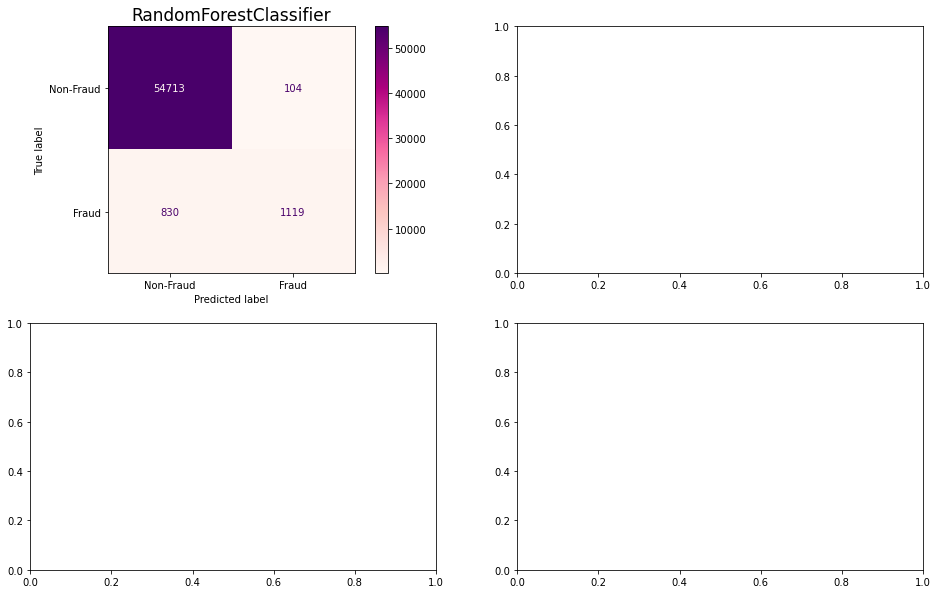

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

for cls, ax in zip([rfc,knn,log], axes.flatten()):
    plot_confusion_matrix(
        cls, 
        X_test, 
        y_test, 
        ax=ax,
        cmap='RdPu',
        display_labels=['Non-Fraud','Fraud'])
    ax.title.set_text(type(cls).__name__)
    ax.title.set_size(17)
plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.suptitle('Confusion Matrices', fontsize=20)
plt.tight_layout()
plt.show;

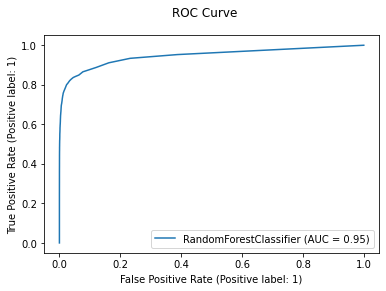

In [24]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc]:
    metrics.plot_roc_curve(mod, X_test, y_test, ax=ax1)
plt.suptitle('ROC Curve ');

In [92]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train);

In [93]:
X_probabilities = rfc.predict_proba(X_test)


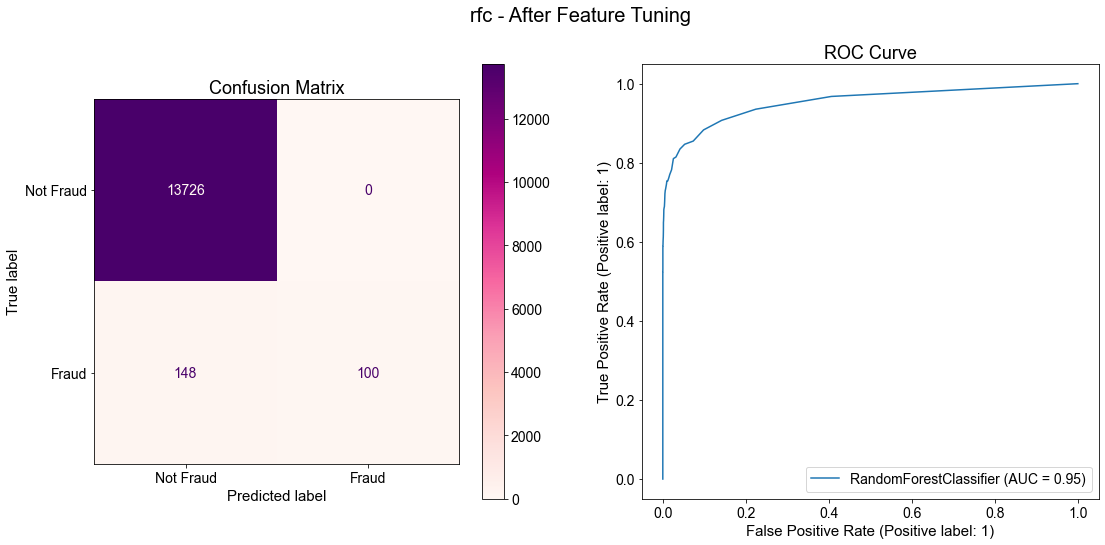

In [99]:
fig, [ax1, ax2] = plt.subplots(1,2)
plot_confusion_matrix(
    rfc, 
    X_test, 
    y_test, 
    cmap='RdPu',
    display_labels=['Non_Fraud','Fraud'],
    ax=ax1)
metrics.plot_roc_curve(rfc, X_test, y_test, ax=ax2)
fig.set_size_inches(18,8)
fig.suptitle('RandomForest Classification ',fontsize=20,y=0.98);
ax1.set_title('Confusion Matrix')
ax2.set_title("ROC Curve")
ax1.title.set_size(18)
ax2.title.set_size(18)
ax1.xaxis.label.set_size(15)
ax2.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)
ax2.yaxis.label.set_size(15);

In [96]:
with open('../models/X_transaction.npy', 'wb') as f:
    np.save(f, X_test['TransactionAmt'])


In [97]:
with open('../models/X_probilities.npy', 'wb') as f:
    np.save(f, X_probabilities)


In [95]:
with open('../models/y_testResuls.npy', 'wb') as f:
    np.save(f, y_test)
